In [1]:
%cd ..

/mnt/cup/labs/hasson/zaid/fmri-convs


- https://brainhack101.github.io/introML-book/01/MAIN_tutorial_intro_to_nilearn.html#visualizing-neuroimaging-volumes
- /jukebox/tamir/ltsoi/Onboarding/sebastian/sam_approach_denoising/output_denoised_wrun


In [2]:
# import sys
# from importlib import reload
# reload(sys.modules['constants'])
# resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e9

In [2]:
from glob import glob

import pickle
import numpy as np
from voxelwise_tutorials.delayer import Delayer
import matplotlib.pyplot as plt
from nilearn.glm.first_level import glover_hrf
from himalaya.viz import plot_alphas_diagnostic
from nilearn.plotting import plot_glass_brain

import pandas as pd
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from util.path import Path
from constants import RUNS, NRUNS, TR

In [9]:
with open('encoding/sub-001/gpt2/sub-001.pkl', 'rb') as f:
    results = pickle.load(f)

In [10]:
len(results['cv_scores'])

5

In [11]:
results['cv_scores'][1].shape

(3, 1000)

In [38]:
sub = 101
conv = "101"
modelname = "gpt2"

load word embeddings

In [39]:
eventpath = Path(
    root="stimuli",
    conv=conv,
    datatype="audio",
    run=1,
    suffix="events",
    ext=".csv",
)

dfs = []
for run in RUNS:
    eventpath = eventpath.update(run=run)
    dft = pd.read_csv(eventpath, index_col=0)
    dfs.append(dft)
dft = pd.concat(dfs)

# keep only condition and when trials start and end
# we have to take line after `trial_intro` because there is the prompt screen
ids = sorted((dft[dft.role == 'trial_intro'].index + 1).tolist() + (dft[dft.role == 'trial_end'].index).tolist())
dft2 = dft.iloc[ids]
dft2 = dft2[dft2.condition == 'G']

dft2

,run,trial,item,condition,role,time.time,run.time,comm.time,audio_position
index,,,,,,,,,
2,1,1.0,1.0,G,listener,1.578505e+09,21.075961,0.000015,0
10,1,1.0,1.0,G,trial_end,1.578505e+09,201.099154,180.023208,5713920
21,1,3.0,3.0,G,speaker,1.578506e+09,423.196448,0.000013,11431936
27,1,3.0,3.0,G,trial_end,1.578506e+09,603.293298,180.096864,17162240
42,2,2.0,5.0,G,listener,1.578507e+09,222.132260,0.000013,28643328
48,2,2.0,5.0,G,trial_end,1.578507e+09,402.162079,180.029833,34373632
54,2,4.0,7.0,G,listener,1.578507e+09,624.260458,0.000013,40124416
59,2,4.0,7.0,G,trial_end,1.578507e+09,804.324111,180.063667,45862912
68,3,2.0,10.0,G,speaker,1.578508e+09,222.124817,0.000015,51605504


load brain data

In [40]:
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=1000, resolution_mm=2)
# NOTE - start with one ROI, neurosynth
# plotting.plot_roi(atlas.maps)

In [42]:
import warnings

boldpath = Path(
    root="data/derivatives/fmriprep",
    sub=f"{sub:03d}",
    ses="1",
    datatype="func",
    task="Conv",
    run=1,
    space="MNI152NLin2009cAsym",
    desc="preproc",
    suffix="bold",
    ext=".nii.gz",
)

confounds = ['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
'a_comp_cor_04','trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
# 'cosine00']

sub_maskers = []
bold_trials = []
for run in RUNS:
    boldpath = boldpath.update(run=run)
    print(run, boldpath.fpath)

    confoundpath = boldpath.copy()
    del confoundpath['space']
    confoundpath.update(desc='confounds', suffix='timeseries', ext='.tsv')
    confound_df = pd.read_csv(confoundpath, sep='\t', usecols=confounds)

    # Resample
    label_masker = NiftiLabelsMasker(labels_img=atlas.maps)
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        fmri_matrix = label_masker.fit_transform(boldpath, confounds=confound_df.to_numpy())
    # print(fmri_matrix.shape)  # 544, 400
    sub_maskers.append(label_masker)

    trial_times = (dft2[dft2.run == run]['run.time'] / TR).round().astype(int).tolist()
    # print(trial_times)
    t1onset, t1offset = trial_times[0:2]
    t2onset, t2offset = trial_times[2:4]

    bold_trials.append(fmri_matrix[t1onset:t1offset])
    bold_trials.append(fmri_matrix[t2onset:t2offset])

print([x.shape for x in bold_trials])
Y_bold = np.vstack(bold_trials)
Y_bold.shape

1 data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/scratch/zzada/cache/conda/envs/fb2b/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


(66, 1000)
[14, 134, 282, 402]
2 data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/scratch/zzada/cache/conda/envs/fb2b/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


(544, 1000)
[148, 268, 416, 536]
3 data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/scratch/zzada/cache/conda/envs/fb2b/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


(544, 1000)
[148, 268, 282, 402]
4 data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/scratch/zzada/cache/conda/envs/fb2b/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


(544, 1000)
[14, 134, 416, 536]
5 data/derivatives/fmriprep/sub-101/ses-1/func/sub-101_ses-1_task-Conv_run-5_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/scratch/zzada/cache/conda/envs/fb2b/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


(544, 1000)
[148, 268, 282, 402]
[(52, 1000), (0, 1000), (120, 1000), (120, 1000), (120, 1000), (120, 1000), (120, 1000), (120, 1000), (120, 1000), (120, 1000)]


(1012, 1000)

In [14]:
# Load embeddings for all runs and trials (as available)
embpath = Path(
    root="embeddings",
    conv="101",
    datatype="gpt2",
    # suffix="transcript",
    ext=".pkl",
)
files = sorted(glob(embpath.starstr(['conv', 'datatype'])))
assert len(files)
dfs = []
for fname in files:
    df = pd.read_pickle(fname)
    dfs.append(df)
dfemb = pd.concat(dfs).reset_index(drop=True)

In [15]:
# Build regressors per TR
stim_trs = 120

X_emb = []
X_pci = []

for (run, trial), subdf in dfemb.groupby(['run', 'trial']):
    print(run, trial, subdf.shape)

    dims = len(subdf.iloc[0].embedding)
    nwords = np.zeros(stim_trs)
    embeddings = np.zeros((stim_trs, dims))
    in_prod = np.zeros(stim_trs, dtype=bool)

    # Go through one TR at a time and find words that fall within this TR
    # average their embeddings, get num of words, etc
    for t in range(stim_trs):
        start_s = t * TR
        end_s = start_s + TR
        mask = (subdf.onset <= end_s) & (subdf.onset > start_s)
        if mask.any():
            nwords[t] = len(subdf)
            in_prod[t] = subdf[mask].speaker.iloc[0] == sub
            embeddings[t] = np.vstack(subdf[mask].embedding).mean(axis=0, keepdims=True)
    in_comp = ~ in_prod

    # Split embeddings into production and comprehension
    prod_embeddings = np.zeros_like(embeddings)
    comp_embeddings = np.zeros_like(embeddings)
    prod_embeddings[in_prod] = embeddings[in_prod]
    comp_embeddings[in_comp] = embeddings[in_comp]
    X_emb.append(np.hstack((prod_embeddings, comp_embeddings)))

    # Convolve prod/comp indicators
    hrf = glover_hrf(TR, oversampling=TR, time_length=32)
    prod_id = np.convolve(in_prod, hrf, mode='same')
    comp_id = np.convolve(in_comp, hrf, mode='same')
    X_pci.append(np.stack((prod_id, comp_id), axis=1))

X_emb = np.vstack(X_emb)
X_pci = np.vstack(X_pci)
X_emb.shape, X_pci.shape

1 1 (742, 18)
1 3 (1067, 18)
2 6 (846, 18)
2 8 (873, 18)
3 10 (996, 18)
3 11 (870, 18)
4 13 (1008, 18)
4 16 (970, 18)
5 18 (924, 18)
5 19 (921, 18)


((1200, 1536), (1200, 2))

In [16]:
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e9

0.00488432

# Modeling

In [17]:
from himalaya.kernel_ridge import MultipleKernelRidgeCV
from himalaya.kernel_ridge import Kernelizer, ColumnKernelizer
from sklearn.pipeline import make_pipeline
from himalaya.scoring import correlation_score, correlation_score_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import make_pipeline

In [18]:
alphas = np.logspace(-1, 8, 10)
alphas

array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07, 1.e+08])

In [19]:
preprocess_pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Kernelizer(kernel="linear"),
)

emb_preprocess_pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[1, 2, 3, 4]),
    Kernelizer(kernel="linear"),
)

In [20]:
# feature_names = ('pc_indicator', 'embedding')
# pipelines = (preprocess_pipeline, emb_preprocess_pipeline)
# slices = [slice(0, 2), slice(2, None)]

feature_names = ('pc_indicator', 'prod', 'comp')
pipelines = (preprocess_pipeline, emb_preprocess_pipeline, emb_preprocess_pipeline)
slices = [slice(0, 2), slice(2, dims+2), slice(dims+2, None)]

slices

[slice(0, 2, None), slice(2, 770, None), slice(770, None, None)]

In [21]:
# Make kernelizer
kernelizers_tuples = [(name, pipe_, slice_)
                      for name, pipe_, slice_ in zip(feature_names, pipelines, slices)]
column_kernelizer = ColumnKernelizer(kernelizers_tuples, n_jobs=len(feature_names))
column_kernelizer

ColumnKernelizer(n_jobs=3,
                 transformers=[('pc_indicator',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler(with_std=False)),
                                                ('kernelizer', Kernelizer())]),
                                slice(0, 2, None)),
                               ('prod',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler(with_std=False)),
                                                ('delayer',
                                                 Delayer(delays=[1, 2, 3, 4])),
                                                ('kernelizer', Kernelizer())]),
                                slice(2, 770, None)),
                               ('comp',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler(with_std=False)),
                                                ('delayer',
                                                 Delayer(delays=[1, 2, 3, 4])),
                                                ('kernelizer', Kernelizer())]),
                                slice(770, None, None))])

In [22]:
mkr_model = MultipleKernelRidgeCV(kernels="precomputed",
                                  solver_params=dict(alphas=alphas, progress_bar=False))  # NOTE try with this
pipeline = make_pipeline(
    column_kernelizer,
    mkr_model,
)
pipeline

Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(n_jobs=3,
                                  transformers=[('pc_indicator',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(0, 2, None)),
                                                ('prod',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[1,
                                                                                  2,
                                                                                  3,
                                                                                  4])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 sli...
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[1,
                                                                                  2,
                                                                                  3,
                                                                                  4])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(770, None, None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed',
                                       solver_params={'alphas': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07, 1.e+08]),
                                                      'progress_bar': False}))])

In [23]:
# https://gallantlab.org/voxelwise_tutorials/_auto_examples/shortclips/06_plot_banded_ridge_model.html

cv_scores = []
cv_models = []
cv_alphas = []

run_ids = np.repeat(np.arange(NRUNS), stim_trs*2)
kfold = PredefinedSplit(run_ids)

for k, (train_index, test_index) in enumerate(kfold.split()):

    print(k, resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e9)

    X_emb_train = X_emb[train_index]
    X_pci_train = X_pci[train_index]
    X_train = np.hstack((X_pci_train, X_emb_train))
    X_test = np.hstack((X_pci[test_index], X_emb[test_index]))

    Y_train = Y_bold[train_index]
    Y_test = Y_bold[test_index]
    Y_train -= Y_train.mean(0)
    Y_test -= Y_test.mean(0)

    pipeline = make_pipeline(
        column_kernelizer,
        mkr_model,
    )
    pipeline['multiplekernelridgecv'].cv = PredefinedSplit(run_ids[train_index])
    pipeline.fit(X_train, Y_train)

    Y_test_pred_split = pipeline.predict(X_test, split=True)
    split_scores_mask = correlation_score_split(Y_test, Y_test_pred_split)

    enc_model = pipeline['multiplekernelridgecv']
    cv_models.append(enc_model)
    cv_scores.append(split_scores_mask)
    cv_alphas.append(enc_model.best_alphas_)

    # break  # NOTE

0 0.00488432
1 0.00488432
2 0.00488432
3 0.00488432
4 0.00488432


In [25]:
result = {
    'masker': sub_maskers[0],
    'cv_models': cv_models,
    'cv_scores': cv_scores,
    'cv_alphas': cv_alphas
}

In [26]:
pklpath = Path(
    root="encoding",
    sub=f"{sub:03d}",
    datatype="gpt2",  # NOTE
    ext=".pkl",
)
pklpath.mkdirs()
with open(pklpath.fpath, 'wb') as f:
    pickle.dump(result, f)

In [98]:
preds1 = pipeline.predict(X_test)
scores1 = correlation_score(Y_test, preds1)

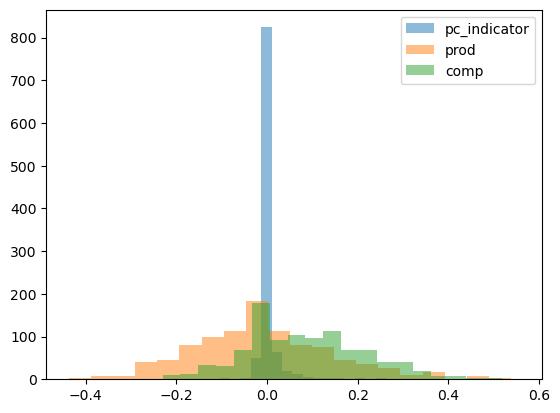

In [95]:
plt.figure()
for i, feature in enumerate(feature_names):
    plt.hist(split_scores_mask[i], alpha=0.5, label=feature, bins=20)
plt.legend()
plt.show()

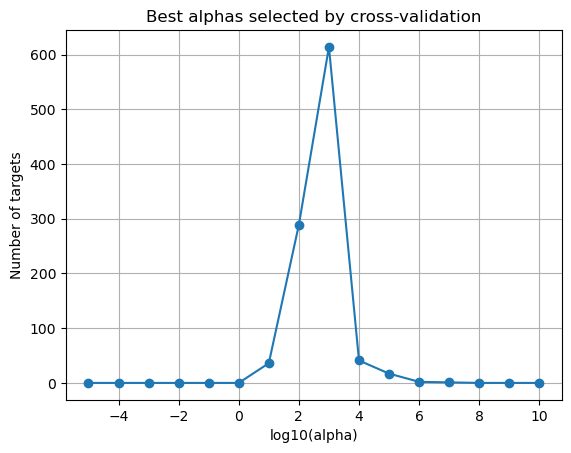

In [96]:
best_alphas = pipeline['multiplekernelridgecv'].best_alphas_
plot_alphas_diagnostic(best_alphas, alphas)
plt.title("Best alphas selected by cross-validation")
plt.show()

In [124]:
all_scores = np.mean(scores, axis=0)
all_scores.shape

(3, 1000)

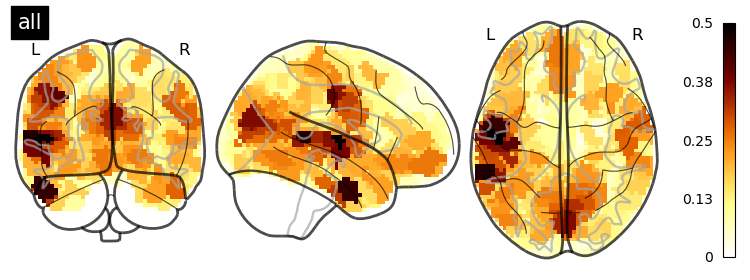

In [132]:
out = sub_maskers[0].inverse_transform(all_scores.sum(0))
plot_glass_brain(out, title='all', colorbar=True, cmap='hot_white_bone_r', plot_abs=True)

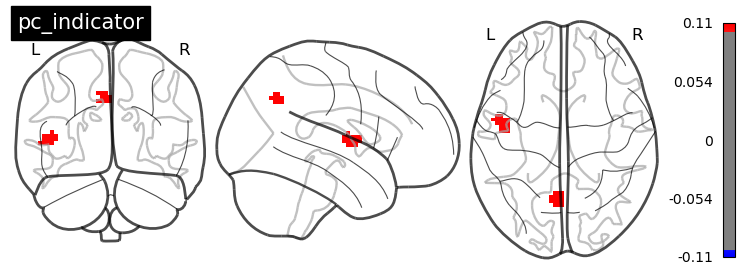

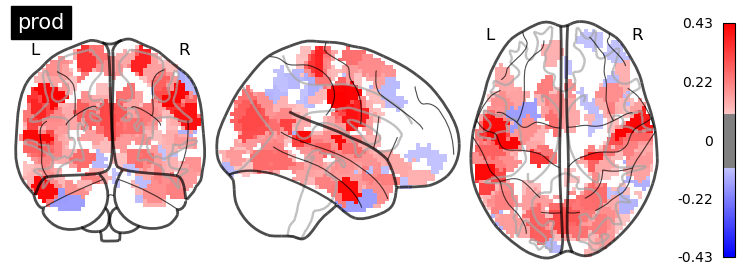

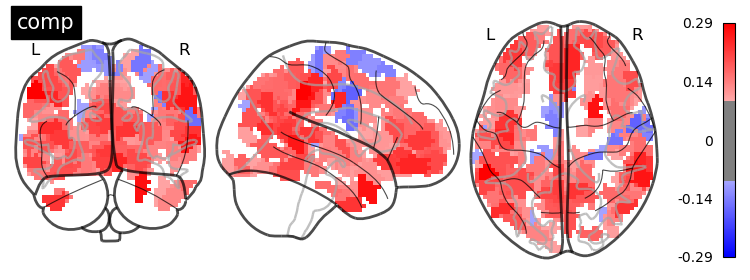

In [123]:
for i, feature in enumerate(feature_names):
    out = sub_maskers[0].inverse_transform(all_scores[i])
    plot_glass_brain(out, title=feature, colorbar=True, cmap='bwr', plot_abs=False, threshold=0.1)